In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

import helper
import vehicle

In [2]:
vehicle_files_dir = './data/vehicles/'
non_vehicle_files_dir = './data/non-vehicles/'

vehicle_files = helper.extract_files(vehicle_files_dir)
non_vehicle_files = helper.extract_files(non_vehicle_files_dir)

print('Number of vehicle files: {}'.format(len(vehicle_files)))
print('Number of non-vehicle files: {}'.format(len(non_vehicle_files)))

Number of vehicle files: 8792
Number of non-vehicle files: 8968


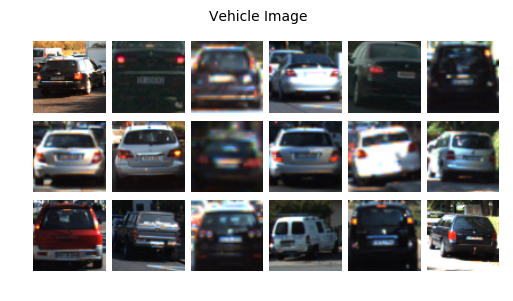

In [3]:
helper.display_random_images(vehicle_files, num_of_images=18, main_title='Vehicle Image')

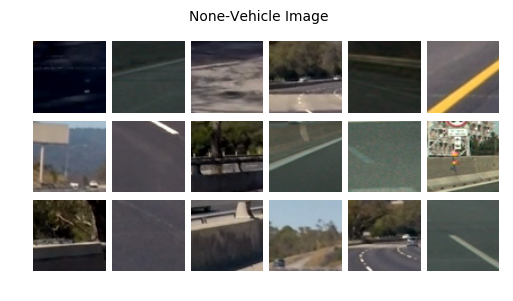

In [4]:
helper.display_random_images(non_vehicle_files, num_of_images=18, main_title='None-Vehicle Image')

(1764,)


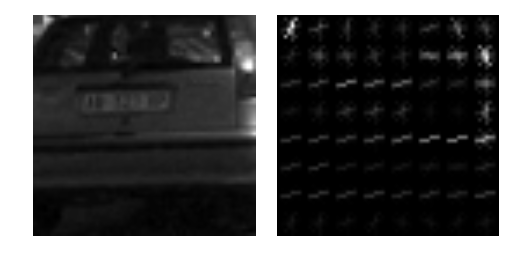

In [5]:
image = mpimg.imread(vehicle_files[0])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


orient = 9
pix_per_cell = 8
cell_per_block = 2

features, hog_image = vehicle.get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

print(features.shape)
# Plot the examples
a = []
b = []
a.append(hog_image)
b.append(gray)
helper.visualize_hog_features(a, b, color_map='gray')

In [6]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [200, None] # Min and max in y to search in slide_window()

feature, _ = vehicle.single_img_features(image, color_space, spatial_size, hist_bins, orient, pix_per_cell, 
                   cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat, vis=True)

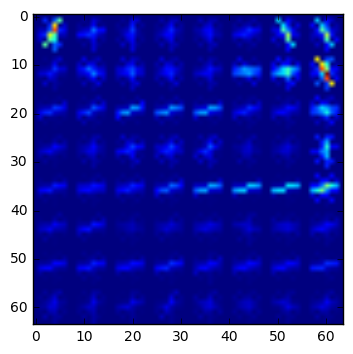

In [7]:
plt.imshow(_)
plt.show()